In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as TD
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.distributions.dirichlet import Dirichlet
from collections import OrderedDict

%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=2) 
torch.set_printoptions(precision=2)
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.7.0].
device:[cuda:2].


In [2]:
def np2tc(x_np): return torch.from_numpy(x_np).float().to(device)
def tc2np(x_tc): return x_tc.detach().cpu().numpy() 
Normalizer = [
    nn.BatchNorm2d,
    nn.InstanceNorm2d,
][1] 

tensor(-1.90)


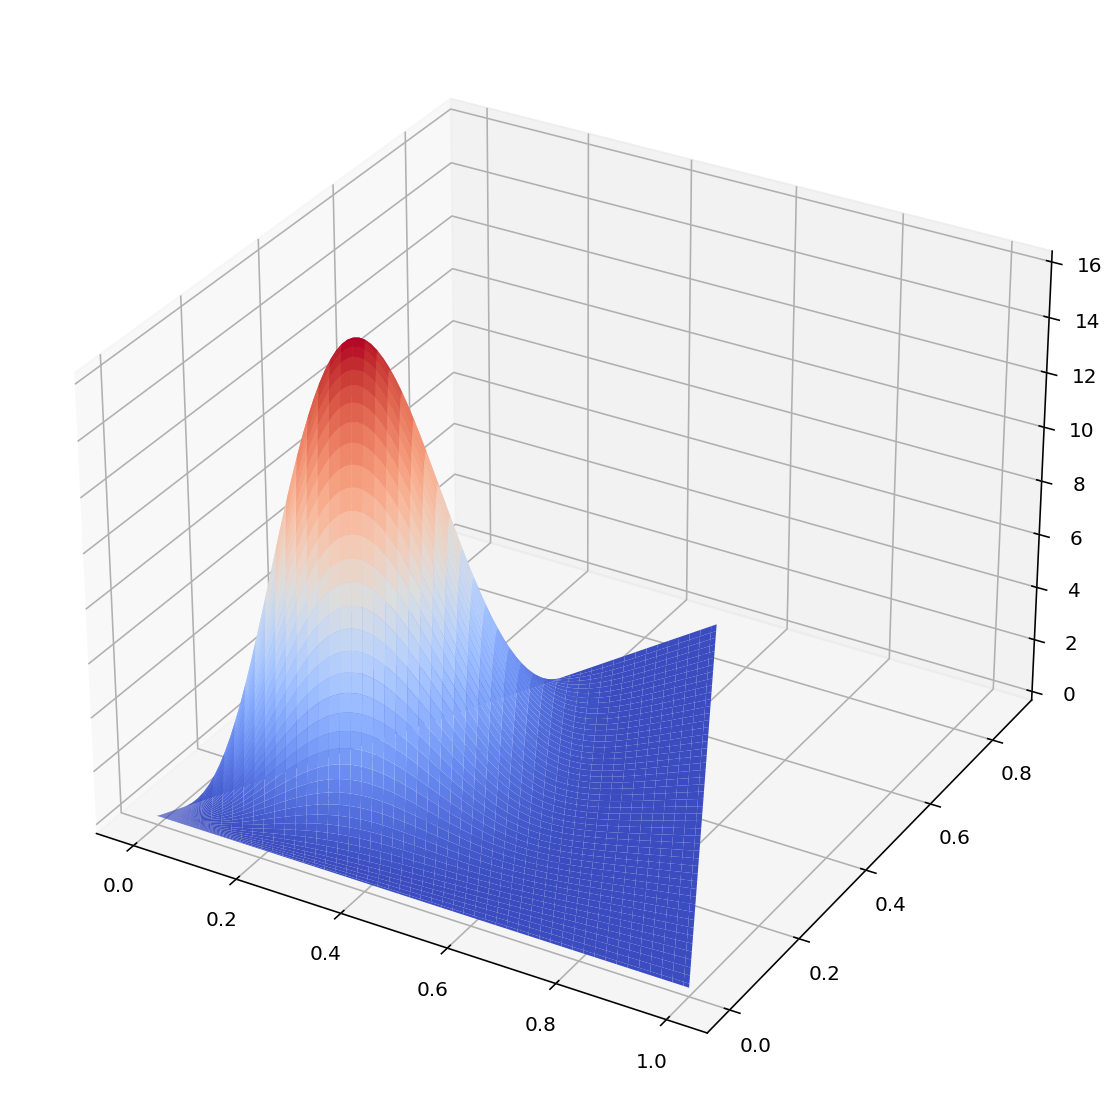

In [3]:
N = 100
diri = Dirichlet(torch.tensor([2., 4., 8.]).repeat(N, N, 1))
mesh = np.linspace(0, 1, N)
k, theta = np.meshgrid(mesh, mesh)
z = torch.exp(diri.log_prob(1e-5 + torch.tensor([
    k * theta, k * (1-theta), 1 - k
]).permute(1, 2, 0)))

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
print(diri.entropy()[0,0])
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d') # Axe3D object
xx = .5 * k * (1 + theta)
yy = 3**.5 * .5 * k * (1 - theta)
ax.plot_surface(xx, yy, tc2np(z), cmap=cm.coolwarm)
plt.show() 

# Build the feature extracter

In [4]:
from PIL import Image
from matplotlib import cm

mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.Compose([
    transforms.ToTensor(), transforms.Resize((32, 32))]),download=True)
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=1,shuffle=True,num_workers=1)
for image, label in train_iter:
    break    

In [5]:
model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=True),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=True),
    nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),
)
model(image).shape

torch.Size([1, 128, 4, 4])

In [6]:
def summarize(name, blocks, x):
    print('='*60)
    print(f'Module [{name}]')
    print(f'\tInput{str(list(x.shape)):>47}')
    with torch.no_grad():
        count_layer = 1
        for i, block in enumerate(blocks):
            x = block(x)
            print(f'\tBlock #{i+1}')
            for layer in block:
                class_name = str(layer.__class__).split(".")[-1].split("'")[0]
                print(f'\t  Layer {f"#{count_layer}":>3} {class_name}')
                count_layer += 1
            print(f'{str(list(x.shape)):>60}')
            
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = None
        self.blocks = None  # list of blocks = list of lists of layers
    def build_graph(self, blocks):
        return nn.ModuleList(map(lambda block: nn.Sequential(*block), blocks))
    def __validate(self):
        assert self.name,   '`self.name` is not defined'
        assert self.blocks, '`self.blocks` is not defined. Build one using self.build_graph(blocks)'
    def summarize(self, x):
        self.__validate()
        summarize(self.name, self.blocks, x) 
    def forward(self, x):
        self.__validate()
        for block in self.blocks:
            x = block(x)
        return x
    
class Extracter(BaseModel):
    def __init__(self, name='Feature Extracter'):
        super().__init__() 
        self.name = name
        blocks = [
            (
                nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=True),
                Normalizer(64),
                nn.ReLU(inplace=True),
            ), (
                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=True),
                Normalizer(128),
                nn.ReLU(inplace=True),
            ), (
                nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),
                Normalizer(128),
                nn.ReLU(inplace=True),  # 4 x 4
            )
        ]
        self.blocks = self.build_graph(blocks)

In [7]:
class ModelPi(BaseModel):
    def __init__(self, dim_k, name='MoL Pi'):
        super().__init__()
        self.name = name
        blocks = [
            (
                nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1, bias=True),
                Normalizer(64),
                nn.ReLU(inplace=True),
            ), (
                nn.Conv2d(64, dim_k, kernel_size=3, stride=2, padding=1, bias=True),
            ), (
                nn.Flatten(),
                nn.Softmax(1),
            )
        ]
        self.blocks = self.build_graph(blocks) 
        
class ModelZ(BaseModel):
    def __init__(self, dim_k, dim_d, name='MoL Z'):
        super().__init__()
        self.name = name
        self.dim_k = dim_k
        self.dim_d = dim_d
        blocks = [
            (
                nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1, bias=True),
                Normalizer(64),
                nn.ReLU(inplace=True),
            ), (
                nn.Conv2d(64, dim_k * dim_d, kernel_size=3, stride=2, padding=1, bias=True),
            ), (
                nn.Flatten(),
            )
        ]
        self.blocks = self.build_graph(blocks)
        
class ModelSigma(BaseModel):
    def __init__(self, dim_k, dim_d, name='MoL Sigma'):
        super().__init__()
        self.name = name
        self.dim_k = dim_k
        self.dim_d = dim_d
        blocks = [
            (
                nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1, bias=True),
                Normalizer(64),
                nn.ReLU(inplace=True),
            ), (
                nn.Conv2d(64, dim_k * dim_d, kernel_size=3, stride=2, padding=1, bias=True),
            ), (
                nn.Flatten(),
            )
        ]
        self.blocks = self.build_graph(blocks) 

In [8]:
class MixtureDirichletPriorNetwork(nn.Module):
    def __init__(self, dim_k=10, dim_d=10, sig_min=.1):
        super().__init__()
        self.dim_k     = dim_k
        self.dim_d     = dim_d
        self.sig_min   = sig_min
        self.build_graph()
        self.init_param()
    def build_graph(self):
        self.extracter   = Extracter()
        self.model_pi    = ModelPi(dim_k=self.dim_k)
        self.model_z     = ModelZ(dim_k=self.dim_k, dim_d=self.dim_d)
        self.model_sigma = ModelSigma(dim_k=self.dim_k, dim_d=self.dim_d)
    def init_param(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            if isinstance(m, nn.Linear): # init dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
        # Heuristic: fc_mu.bias ~ Uniform(mu_min,mu_max)
        # list(self.model_mu.modules())[-1].bias.data.uniform_(self.mu_min,self.mu_max)
    def summarize(self, x):
        self.extracter.summarize(x)
        with torch.no_grad():
            f = self.extracter(x)
        self.model_pi.summarize(f)
        self.model_z.summarize(f)
        self.model_sigma.summarize(f)
    def forward(self, x):
        # z --[exp]--> alpha --[normalize]--> mu
        f     = self.extracter(x)
        
        pi    = self.model_pi(f)  # [N x K]
        z     = self.model_z(f)  # [N x KD]
        z     = z.reshape(-1, self.dim_k, self.dim_d)  # [N x K x D]
        sigma = self.sig_min + torch.exp(self.model_sigma(f))  # [N x KD]
        sigma = sigma.reshape(-1, self.dim_k, self.dim_d)  # [N x K x D]
        return {'pi': pi, 'z': z, 'sigma': sigma}
    
x = torch.randn(4, 1, 32, 32)  # demo [N x C x H x W]
mdpn = MixtureDirichletPriorNetwork(dim_k=5)
mdpn.summarize(x)
pi, z, sigma = mdpn(x).values()
pi.shape, z.shape, sigma.shape, sigma

Module [Feature Extracter]
	Input                                 [4, 1, 32, 32]
	Block #1
	  Layer  #1 Conv2d
	  Layer  #2 InstanceNorm2d
	  Layer  #3 ReLU
                                             [4, 64, 16, 16]
	Block #2
	  Layer  #4 Conv2d
	  Layer  #5 InstanceNorm2d
	  Layer  #6 ReLU
                                              [4, 128, 8, 8]
	Block #3
	  Layer  #7 Conv2d
	  Layer  #8 InstanceNorm2d
	  Layer  #9 ReLU
                                              [4, 128, 4, 4]
Module [MoL Pi]
	Input                                 [4, 128, 4, 4]
	Block #1
	  Layer  #1 Conv2d
	  Layer  #2 InstanceNorm2d
	  Layer  #3 ReLU
                                               [4, 64, 2, 2]
	Block #2
	  Layer  #4 Conv2d
                                                [4, 5, 1, 1]
	Block #3
	  Layer  #5 Flatten
	  Layer  #6 Softmax
                                                      [4, 5]
Module [MoL Z]
	Input                                 [4, 128, 4, 4]
	Block #1
	  Layer  #1 Conv2

(torch.Size([4, 5]),
 torch.Size([4, 5, 10]),
 torch.Size([4, 5, 10]),
 tensor([[[0.58, 3.34, 0.37, 0.52, 1.00, 3.19, 0.95, 0.44, 2.49, 1.30],
          [0.90, 1.88, 1.39, 0.59, 0.90, 0.84, 2.67, 0.72, 0.64, 1.18],
          [1.25, 1.77, 1.41, 1.42, 0.94, 0.34, 2.94, 1.01, 0.33, 1.61],
          [1.58, 1.89, 0.77, 1.23, 1.21, 0.98, 0.56, 0.68, 0.68, 0.83],
          [1.94, 0.76, 0.79, 0.34, 1.13, 1.10, 2.03, 0.84, 1.63, 1.45]],
 
         [[1.40, 3.25, 0.33, 0.71, 1.06, 6.36, 0.34, 1.44, 1.59, 1.09],
          [0.73, 1.72, 2.94, 1.10, 1.87, 1.14, 0.77, 1.10, 0.53, 1.43],
          [1.17, 1.04, 1.10, 0.76, 0.81, 0.46, 1.15, 1.33, 0.34, 1.30],
          [1.04, 0.74, 1.16, 0.32, 1.24, 0.38, 1.46, 2.58, 1.83, 0.69],
          [2.21, 0.50, 0.88, 0.41, 1.56, 2.26, 0.61, 2.05, 1.83, 2.05]],
 
         [[0.81, 6.51, 0.36, 0.60, 0.49, 0.92, 0.51, 2.31, 1.21, 0.69],
          [1.05, 1.81, 1.07, 0.63, 2.43, 1.29, 1.04, 0.94, 0.81, 1.00],
          [1.35, 1.25, 1.33, 0.49, 0.33, 0.52, 2.67, 1.79, 

# 하... appendix에 있었네...
### Total Entropy
$$\mathcal{H} \left [
\iint P(y|\mathbf{\mu})
p(\mathbf{\mu}|\mathbf{x}^*, \mathbf{\theta})
p(\mathbf{\theta}|\mathcal{D})
d\mathbf{\mu}d\mathbf{\theta}
\right ] \approx \mathcal{H} \left [
\sum_k \pi_k P \left (y|\mathbf{x}^*, \hat{\mathbf{\theta}}_k \right )
\right ] = \mathcal{H} \left [
y \left | \sum_k \pi_k \mathbf{\mu}_k \right .
\right ]$$

### Expected Data Uncertainty for MDN Ensemble
- $y$의 pmf가 그냥 $\mu$라서 계산은 쉬움
- Total에서 빼면 $y$, $\theta$간 mutual information임
- Data uncertainty를 잡을 수 있음
$$\int \mathcal{H} \left [
\int P(y|\mathbf{\mu})
p(\mathbf{\mu}|\mathbf{x}^*, \mathbf{\theta})d\mathbf{\mu}
\right ]
p(\mathbf{\theta}|\mathcal{D})
d\mathbf{\theta} = \int \mathcal{H} \left [
y \left | \text{ softmax} \left ( f_\theta \left ( \mathbf{x}^* \right ) \right ) \right . \right ] p(\mathbf{\theta}|\mathcal{D})  d\mathbf{\theta} \\
\approx \sum_k \pi_k \mathcal{H} \left [y|\mu_k \right ]$$

### Expected Data Uncertainty for DPN Ensemble(?)
- pdf weighting하는 건 빡셈
- 그래서 그냥 밖으로 뽑음
- Total에서 빼면 $y$, $\mu$간 mutual information임
- Distributional uncertainty를 잡을 수 있음
$$\int \mathcal{H} \left [ P(y|\mathbf{\mu}) \right ] \left [ 
\int p(\mathbf{\mu}|\mathbf{x}^*, \mathbf{\theta})
p(\mathbf{\theta}|\mathcal{D}) d\mathbf{\theta}
\right ] d\mathbf{\mu} \approx \sum_k \pi_k \sum_c \mathbf{\mu}_c \left [ \psi (\alpha_0 + 1) - \psi (\alpha_c + 1) \right ]$$

### Differential Entropy
- 진짜 걍 network output에 디리클레 주고 엔트로피 구하면 됨
- Differential은 연속적이라는 뜻임
$$\mathcal{H}[p(\mathbf{\mu}|\mathbf{x}^*; \mathcal{D})] = -\int_{\mathcal{S}^{D-1}} p(\mathbf{\mu}|\mathbf{x}^*;\mathcal{D})\ln \left ( p(\mathbf{\mu}|\mathbf{x}^*;\mathcal{D}) \right ) d\mathbf{\mu}$$

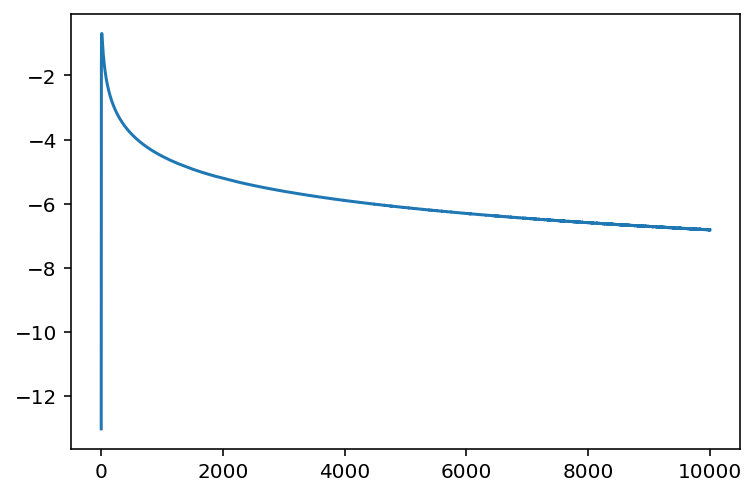

In [9]:
x = np.linspace(.1, 1000, 10000).reshape(-1, 1).repeat(3, 1)
y = Dirichlet(np2tc(x)).entropy()
plt.plot(tc2np(y))
plt.show() 

In [10]:
Dirichlet(torch.tensor([3., 3., 3.])).entropy()

tensor(-1.22)

In [11]:
EPS = 1e-6
def mdpn_uncertainties(pi, z, sigma, alpha_min=.5):
    """
        :param pi:   [N x K]
        :param z:    [N x K x D]
        :param sigma:[N x K x D]
    """
    alpha  = torch.exp(z) + alpha_min  # [N x K x D]
    alpha0 = torch.sum(alpha, axis=2, keepdim=True)  # [N x K x 1]
    mu = alpha / alpha0  # [N x K x D]
    pi_usq = pi.unsqueeze(2)  # [N x K x 1]
    
    # max probability
    z_hat = torch.sum(pi_usq * z, axis=1)  # [N x D]
    alpha_hat = torch.softmax(z_hat, axis=1)  # [N x D]
    max_p = torch.max(alpha_hat, axis=1)[0]  # [N]
    
    # Total entropy
    mu_hat = torch.sum(pi_usq * mu, axis=1)  # [N x D]
    total_entropy = torch.sum(- mu_hat * torch.log(mu_hat), axis=1)  # [N]
    
    # Mutual information for MDN ensemble (model unct.)
    data_unct_mdn = - torch.sum(mu * torch.log(mu), axis=2)  # [N x K]
    data_unct_mdn = torch.sum(pi * data_unct_mdn, axis=1)  # [N]
    MI_mdn = total_entropy - data_unct_mdn  # [N]
    
    # Mutual information for DPN (dist. unct.)
    data_unct_dpn = torch.sum(
        mu * (torch.digamma(alpha0+1+EPS) - torch.digamma(alpha+1+EPS)), axis=2)  # [N x K]
    data_unct_dpn = torch.sum(pi * data_unct_dpn, axis=1)  # [N]
    MI_dpn = total_entropy - data_unct_dpn  # [N]
    
    # Differential entropy (dist. unct.)
    DE = Dirichlet(alpha).entropy()  # [N x K]
    DE *= pi  # [N x K]
    DE = DE.sum(axis=1)  # [N]
    
    unct_out = {
        'max_p': max_p,
        'H': total_entropy,
        'E_data_mdn': data_unct_mdn,
        'E_data_dpn': data_unct_dpn,
        'MI_mdn': MI_mdn,
        'MI_dpn': MI_dpn,
        'DE': DE,
    }
    return unct_out

def mdpn_loss(pi, z, target_alpha, sigma, alpha_min=.5):
    """
        :param pi:             [N x K]
        :param z:              [N x K x D]
        :param target_alpha:   [N x D]
        :param sigma:          [N x K x D]
    """
    alpha  = torch.exp(torch.sum(pi.unsqueeze(2) * z, axis=1)) + alpha_min  # [N x D]
    alpha0 = alpha.sum(axis=1)  # [N]
    target_alpha0 = target_alpha.sum(axis=1)  # [N]
    
    unct_out = mdpn_uncertainties(pi, z, sigma)
    
    # KL Divergence
    DKL = (
           torch.lgamma(target_alpha0+EPS) - torch.lgamma(alpha0+EPS)
        + (torch.lgamma(alpha+EPS) - torch.lgamma(target_alpha+EPS)).sum(axis=1)
        + (
            (target_alpha - alpha) *
            (torch.digamma(target_alpha+EPS) - torch.digamma(target_alpha0.unsqueeze(1)+EPS))
        ).sum(axis=1)
    )  # [N]
    
    # Cross-entropy (logit belended)
    mu = alpha / alpha0.unsqueeze(1)  # [N x D]
    target_mu = target_alpha / target_alpha0.unsqueeze(1)  # [N x D]
    CE = - torch.sum(target_mu * torch.log(mu+1e-6), axis=1)  # [N]
    
    # MACE
    sigma_k  = sigma  # [N x K x D]
    alpha_k  = torch.exp(z) + alpha_min  # [N x K x D]
    alpha0_k = alpha_k.sum(axis=2)  # [N x K]
    mu_k     = torch.softmax(alpha_k, axis=2)  # [N x K x D]
    CE_exp   = mu_k * -torch.log(mu_k+1e-6)  # [N x K x D]
    ACE_exp  = CE_exp / sigma_k  # [N x K x D]
    ACE_exp  = ACE_exp.sum(axis=2)  # [N x K]
    MACE     = torch.sum(pi * ACE_exp, axis=1)  # [N] 
    
    loss_out = {
        # losses
        'DKL': DKL,
        'CE': CE,
        'MACE': MACE,
        # unct. measures
        'max_p': unct_out['max_p'], 
        'H': unct_out['H'], 
        'E_data_mdn': unct_out['E_data_mdn'], 
        'E_data_dpn': unct_out['E_data_dpn'], 
        'MI_mdn': unct_out['MI_mdn'], 
        'MI_dpn': unct_out['MI_dpn'], 
        'DE': unct_out['DE'], 
    }
    
    loss_out['DKL_avg'] = DKL.mean()
    loss_out['CE_avg'] = CE.mean() 
    loss_out['MACE_avg'] = MACE.mean() 
    loss_out['max_p_avg'] = loss_out['max_p'].mean()
    loss_out['H_avg'] = loss_out['H'].mean()
    loss_out['E_data_mdn_avg'] = loss_out['E_data_mdn'].mean()
    loss_out['E_data_dpn_avg'] = loss_out['E_data_dpn'].mean()
    loss_out['MI_mdn_avg'] = loss_out['MI_mdn'].mean()
    loss_out['MI_dpn_avg'] = loss_out['MI_dpn'].mean()
    loss_out['DE_avg'] = loss_out['DE'].mean()
    
    return loss_out

M = MixtureDirichletPriorNetwork(dim_k=10).to(device)
x = torch.randn(2, 1, 32, 32).to(device)
target_alpha = .03*torch.ones(2, 10).to(device)
target_alpha[0, torch.randint(10,[2]).to(device)] = 3.  # in-dist. target_alpha
mdpn_out = M(x)
pi, z, sigma = mdpn_out['pi'], mdpn_out['z'], mdpn_out['sigma']
alpha = torch.exp(z) + .5
loss_out = mdpn_loss(pi, z, target_alpha, sigma)
loss = loss_out['DKL_avg'] + loss_out['CE_avg'] + loss_out['DE_avg'] + loss_out['MACE_avg']
loss.backward() # backward propagation
print ("x:       %s"%(tc2np(x).shape,))
print ("\n=>")
print ("pi     %s\n%s"%(tc2np(pi).shape,tc2np(pi)))
print ("alpha: %s\n%s"%(tc2np(alpha).shape,tc2np(alpha)))
print ("sigma: %s\n%s"%(tc2np(sigma).shape,tc2np(sigma)))
print ("\n=>")
for key in loss_out:
    if 'avg' in key:
        print(f'{key:14} [ {loss_out[key]:7.3f} ]')

x:       (2, 1, 32, 32)

=>
pi     (2, 10)
[[0.06 0.13 0.05 0.26 0.03 0.06 0.1  0.07 0.05 0.2 ]
 [0.16 0.25 0.07 0.11 0.05 0.09 0.1  0.06 0.03 0.08]]
alpha: (2, 10, 10)
[[[1.22 2.98 1.23 1.13 0.72 2.28 2.3  0.87 1.26 1.37]
  [1.28 1.57 2.18 1.97 1.38 1.6  0.95 4.07 1.83 1.24]
  [1.06 1.41 1.38 0.81 1.5  1.12 1.97 3.83 1.48 0.73]
  [1.45 2.1  0.88 1.11 1.32 1.01 3.33 2.13 1.17 2.09]
  [2.13 2.44 1.25 1.92 1.03 2.56 1.36 1.82 2.33 1.15]
  [1.71 1.34 2.53 1.91 2.47 2.29 1.7  1.43 8.86 1.95]
  [1.32 0.72 1.08 1.76 1.59 0.73 1.16 2.99 2.29 1.17]
  [1.01 2.59 1.68 4.81 1.1  1.09 2.29 2.47 2.81 2.69]
  [1.22 2.63 1.31 1.14 1.15 1.6  1.13 2.54 2.37 0.72]
  [2.94 1.53 1.92 1.45 1.55 1.16 0.79 2.56 1.16 0.7 ]]

 [[1.52 1.61 1.87 2.22 1.02 2.02 2.5  1.29 1.76 2.25]
  [1.07 1.   1.55 1.1  1.28 1.32 1.08 3.41 0.99 1.38]
  [1.86 3.14 2.01 0.9  1.2  2.65 2.   1.16 2.18 0.97]
  [1.14 6.56 0.71 1.58 1.89 0.93 2.15 1.08 2.08 1.03]
  [0.97 0.92 0.82 2.66 1.35 1.82 2.51 2.8  1.31 1.47]
  [2.43 1.14 2.43 2

In [12]:
raw_mnist_train  = datasets.MNIST(root='./data/', train=True, download=True)
raw_mnist_test   = datasets.MNIST(root='./data/', train=False, download=True)
mnist_train_dict = {i: [] for i in range(10)}
mnist_test_dict  = {i: [] for i in range(10)}
for image, target in raw_mnist_train:
    mnist_train_dict[target].append(image)
for image, target in raw_mnist_test:
    mnist_test_dict[target].append(image)
    
def get_filtered_MNIST(train=True, labels=[0, 1, 2, 3, 4]):
    mnist_dict = mnist_train_dict if train else mnist_test_dict
    output = {'images': [], 'labels': []}
    for l in labels:
        output['images'] += mnist_dict[l]
        output['labels'] += [l] * len(mnist_dict[l])
    return output

In [13]:
class FilteredMNIST(Dataset):
    def __init__(self, alpha0=3., EPS=1e-2, train=True, in_dist=True, labels=[0, 1, 2, 3, 4]):
        super().__init__()
        self.alpha0 = alpha0
        self.EPS = EPS
        self.in_dist = in_dist
        self.train = train
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0., 1.),
            transforms.Resize((32, 32)),
        ])
        self.dataset = get_filtered_MNIST(train, labels)
        self.dataset['labels'] = np.array(self.dataset['labels'])
    def __getitem__(self, index):
        x     = self.dataset['images'][index]
        label = self.dataset['labels'][index]
        x     = self.transform(x) 
        if not self.train or self.in_dist:
            y = torch.ones(10) * self.EPS
            y[label] = 1 - 9 * self.EPS
            y *= self.alpha0
        else:  # out-of-distribution
            y = torch.ones(1)
        return x, y, self.in_dist
    def __len__(self):
        return len(self.dataset['images'])
    
def get_train_iter(BATCH_SIZE=32, rs_rate=0.0, in_dist=True, labels=[0, 1, 2, 3, 4]):
    mnist_train = FilteredMNIST(train=True, in_dist=in_dist, labels=labels)
    n_train = len(mnist_train) 
    if rs_rate > 0:
        n_rs = int(n_train*rs_rate) 
        r_idx = np.random.permutation(n_train)[:n_rs]
        mnist_train.dataset['labels'][r_idx] = torch.randint(low=0,high=10,size=(n_rs,)) # random label 
    return torch.utils.data.DataLoader(
        mnist_train, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=0)
def get_test_iter(BATCH_SIZE=1, in_dist=True, labels=[0, 1, 2, 3, 4]):
    mnist_train = FilteredMNIST(train=False, in_dist=in_dist, labels=labels)
    return torch.utils.data.DataLoader(
        mnist_train, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=0)

def merge_dataloader(*loaders):
    loaders = list(map(iter, loaders))
    while True:
        index = np.random.randint(len(loaders))
        selected = loaders[index]
        try:
            yield next(selected)
        except StopIteration:
            loaders.remove(selected)
        if len(loaders)==0:
            break

# Dataset Test

In [14]:
for x, y, info in get_train_iter(1): break
with torch.no_grad():
    mdpn_out = M(x.to(device)) 
pi, z = mdpn_out['pi'], mdpn_out['z']
print(pi.shape, z.shape, y.shape)
print(pi, z, y) 

torch.Size([1, 10]) torch.Size([1, 10, 10]) torch.Size([1, 10])
tensor([[0.24, 0.10, 0.11, 0.08, 0.03, 0.11, 0.05, 0.12, 0.06, 0.10]],
       device='cuda:2') tensor([[[ 0.82, -1.19,  0.28, -0.53, -1.03,  0.18,  0.72,  0.17,  0.81,  0.43],
         [ 0.57, -0.24,  0.16, -0.48, -0.50, -0.23, -0.17,  0.57, -0.07, -0.26],
         [-0.79,  0.25,  0.01, -0.57, -1.17,  0.47, -0.48, -0.70, -0.23, -0.95],
         [ 0.13,  0.35, -0.52,  0.42, -0.23, -0.65,  0.81,  1.04, -0.14, -0.28],
         [-0.15, -0.45,  0.15,  0.11, -0.08,  0.63,  0.63,  0.61,  0.45, -0.23],
         [-0.21, -0.79,  1.20,  0.58, -0.02,  1.32, -0.19, -0.31,  1.48,  1.25],
         [-0.26, -0.34, -0.98, -0.54,  0.82, -0.95,  0.31,  0.39,  0.45, -0.88],
         [-0.87, -0.85,  0.55,  0.09, -0.44,  0.90,  0.82,  0.85,  0.95,  0.20],
         [ 0.42,  0.61,  0.41, -1.65, -0.23, -0.69, -0.24,  0.53,  0.75,  0.42],
         [-0.82,  0.84,  0.30,  0.11,  0.15,  0.33, -1.28,  0.56, -1.75, -0.48]]],
       device='cuda:2') tenso

In [15]:
def func_eval(model, data_iter, device):
    n_total, n_correct = 0, 0
    measures = ['max_p', 'H', 'E_data_mdn', 'E_data_dpn', 'MI_mdn', 'MI_dpn', 'DE']
    measures = {name: 0 for name in measures}
    model.eval() # evaluate (deactivates DropOut and BN)
    for i, (batch_in, batch_out, batch_in_dist) in enumerate(data_iter):
        if i == len(data_iter) // 10:
            break
        # Forward path
        y_trgt = torch.argmax(batch_out.to(device), axis=1)
        with torch.no_grad():
            mdpn_out = model(batch_in.to(device))
        pi, z, sigma = mdpn_out['pi'], mdpn_out['z'], mdpn_out['sigma']
        z_hat        = torch.sum(pi.unsqueeze(2)*z, axis=1)  # [N x D]
        y            = torch.argmax(z_hat, axis=1)  # args: [N]
        correct      = (y==y_trgt).sum().item()
        
        unct_out = mdpn_uncertainties(pi, z, sigma)
        for name in measures:
            measures[name] += torch.sum(unct_out[name])

        n_correct += correct
        n_total += batch_in.shape[0]  # N
        
    val_accr = (n_correct/n_total)
    for name in measures:
        measures[name] = tc2np(measures[name]/n_total)
    model.train() # back to train mode 
    return {
        'Acc': val_accr,
        **measures,
    }

def train_wrapper(dim_k=10, EPOCHS=10):
    np.set_printoptions(formatter={'float_kind':'{:.2f}'.format}) 
    M = MixtureDirichletPriorNetwork(dim_k=dim_k).to(device)
    np.random.seed(seed=0)
    torch.manual_seed(seed=0) # fix random seed
    optm = optim.Adam(M.parameters(), lr=1e-3, weight_decay=1e-6)
    M.train() # train mode
    train_iter_in  = get_train_iter(BATCH_SIZE=64, labels=[0, 1, 2, 3], rs_rate=.8)
    train_iter_out = get_train_iter(BATCH_SIZE=64, labels=[4, 5, 6], in_dist=False)
    test_iter_in   = get_test_iter(BATCH_SIZE=64, labels=[0, 1, 2, 3])
    test_iter_out  = get_test_iter(BATCH_SIZE=64, labels=[4, 5, 6], in_dist=False)  # test에서는 in_dist
    test_iter_real = get_test_iter(BATCH_SIZE=64, labels=[7, 8, 9], in_dist=False)  # 아무 효과 x
    print_every = 1
    for epoch in range(EPOCHS):
        loss_sum = 0.0
        for batch_in, batch_out, batch_in_dist in merge_dataloader(train_iter_in, train_iter_out):
            # Forward path
            mdpn_out = M(batch_in.to(device)) 
            pi, z, sigma = mdpn_out['pi'], mdpn_out['z'], mdpn_out['sigma']
            target = batch_out.to(device) 
            loss_out = mdpn_loss(pi, z, target, sigma)
            
            ones = -torch.ones(batch_in.shape[0]).to(device) 
            ones[batch_in_dist.to(device)] = 1
            loss = (
                loss_out['CE_avg']
#                 loss_out['MACE_avg']
                + loss_out['E_data_mdn_avg']
#                 + 1e-2 * loss_out['DKL_avg']
#                 + 1e1  * loss_out['MI_mdn_avg']
            )
            loss += torch.mean(ones * (
                        loss_out['MI_dpn']
#                 + .05 * loss_out['DE']
            ))
            
            # Update 
            optm.zero_grad() # reset gradient 
            loss.backward() # back-propagation 
            optm.step() # optimizer update
            # Track losses 
            loss_sum += loss
        loss_avg = loss_sum/len(train_iter)
        # Print
        if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
            train_in_res  = func_eval(M,train_iter_in,device)
            train_out_res = func_eval(M,train_iter_out,device)
            test_in_res   = func_eval(M,test_iter_in,device)
            test_out_res  = func_eval(M,test_iter_out,device)
            test_real_res = func_eval(M,test_iter_real,device)
            print(f'epoch:[{epoch}/{EPOCHS}] loss: {loss_avg:.3f}')
            for res_type, result in zip(
                ['Train(in)', 'Train(out)',   'Test(in)',  'Test(out)',  'Test(real)'],
                [train_in_res, train_out_res, test_in_res, test_out_res, test_real_res]):
                print(f'[{res_type:10}] ' + ' '.join([f'{name.replace("E_data_", "D")}:{result[name]:.3f}' for name in result]))
            print()
    out = {
        'M':M,
        'train_iter_in':train_iter_in,
        'train_iter_out':train_iter_out,
        'test_iter_in': test_iter_in,
        'test_iter_out': test_iter_out,
        'test_iter_real': test_iter_real,
    }
    return out 
print ("Done.")

Done.


In [16]:
out1 = train_wrapper(dim_k=10, EPOCHS=10)

epoch:[0/10] loss: 0.116
[Train(in) ] Acc:0.278 max_p:0.429 H:0.533 Dmdn:0.039 Ddpn:0.037 MI_mdn:0.494 MI_dpn:0.497 DE:-65.987
[Train(out)] Acc:0.445 max_p:0.264 H:1.008 Dmdn:0.023 Ddpn:0.022 MI_mdn:0.984 MI_dpn:0.986 DE:-72.710
[Test(in)  ] Acc:0.948 max_p:0.433 H:0.531 Dmdn:0.039 Ddpn:0.037 MI_mdn:0.492 MI_dpn:0.495 DE:-66.014
[Test(out) ] Acc:0.000 max_p:0.268 H:1.037 Dmdn:0.023 Ddpn:0.021 MI_mdn:1.014 MI_dpn:1.016 DE:-72.898
[Test(real)] Acc:0.000 max_p:0.314 H:0.532 Dmdn:0.034 Ddpn:0.032 MI_mdn:0.498 MI_dpn:0.500 DE:-67.221

epoch:[1/10] loss: 0.112
[Train(in) ] Acc:0.276 max_p:0.405 H:0.370 Dmdn:0.036 Ddpn:0.034 MI_mdn:0.334 MI_dpn:0.336 DE:-63.535
[Train(out)] Acc:0.157 max_p:0.173 H:1.525 Dmdn:0.008 Ddpn:0.008 MI_mdn:1.517 MI_dpn:1.518 DE:-88.004
[Test(in)  ] Acc:0.885 max_p:0.408 H:0.370 Dmdn:0.036 Ddpn:0.034 MI_mdn:0.333 MI_dpn:0.336 DE:-63.492
[Test(out) ] Acc:0.035 max_p:0.169 H:1.603 Dmdn:0.007 Ddpn:0.006 MI_mdn:1.596 MI_dpn:1.597 DE:-89.900
[Test(real)] Acc:0.000 max_p:0.

In [17]:
def presenter2(model, x, y):
    index = np.random.randint(x.shape[0])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    tmp = model(x.to(device))
    index = np.random.randint(tmp['pi'].shape[0])
    pi = tmp['pi']
    z = tmp['z']
    mu_hat = tc2np(torch.softmax(z, 2)[index])
    
    label = tc2np(torch.argmax(y, axis=1))
    pred = np.argmax(tc2np(torch.softmax(torch.sum(pi.unsqueeze(2)*z, axis=1), 1)[index]))
    ax1.set_title(f'label: [{label[index]}], pred: [{pred}]')
    ax1.imshow(x[index].squeeze()); ax1.axis('off')
               
    ax2.set_title(r'$\mu$')
    im = ax2.imshow(mu_hat)
    ax2.set_ylabel(r'$\pi$')
    ax2.set_xlabel('label')
    ax2.set_xticks(np.arange(9)+.5)
    ax2.set_yticks(np.arange(9)+.5)
    ax2.grid(axis='y')
    ax2.grid(axis='x', alpha=.3)
    
    ax3.set_title(r'$\pi$')
    pi = tc2np(pi[index]) 
    ax3.imshow(pi[:,None], aspect=1); ax3.axis('off')
    
    fig.tight_layout()
    plt.subplots_adjust(left=0, right=1)
    plt.show() 

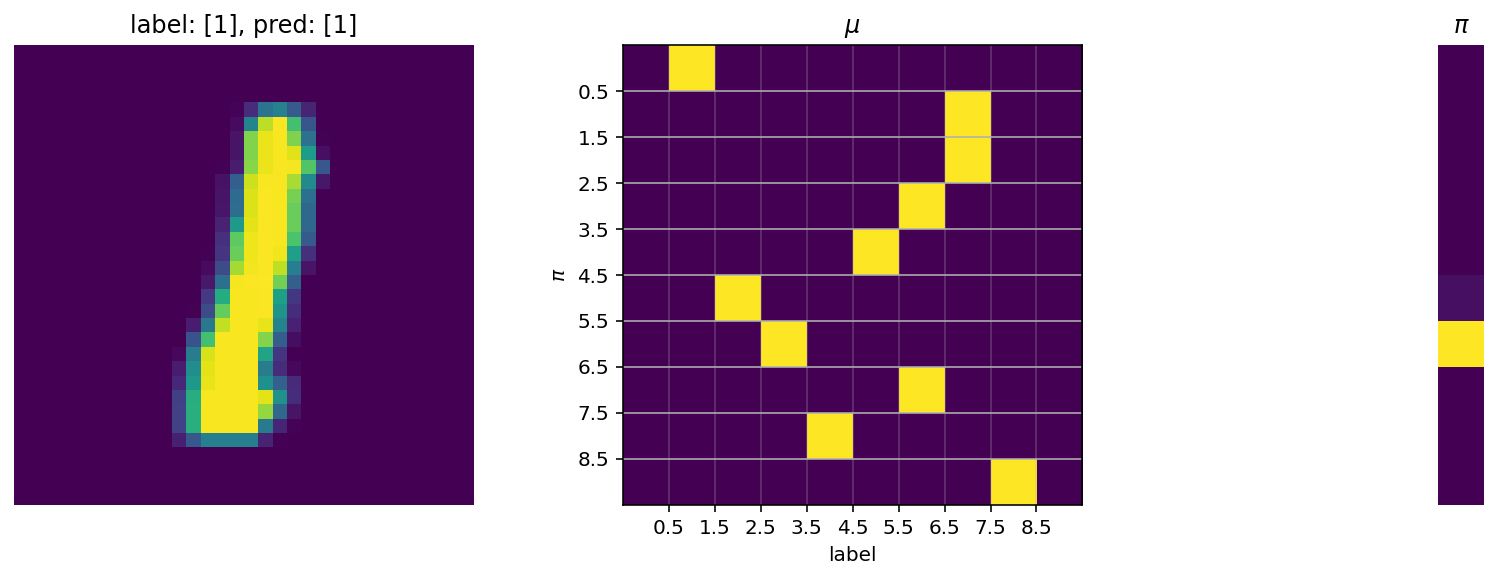

In [25]:
for x, y, _ in out1['test_iter_in']: break
M = out1['M']
presenter2(M, x, y)